# Prerequisites

In [ ]:
# instalacja TensorFlow Hub
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import bibliotek
from PIL import Image
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd 
from sklearn.metrics import accuracy_score
import cv2

# Output configuration

In [ ]:
# połączenie projektu z dyskiem Google, dzie znajdują się pliki .zip ze zbiorami danych
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
model_dir = '/content/gdrive/My Drive/Colab Notebooks'

# zdefiniowanie ścieżek wyjść (output path)
OUTPUT_ROOT_DIR = os.path.join(model_dir, "/output")
OUTPUT_TFLITE_MODEL = os.path.join(OUTPUT_ROOT_DIR, "/retrained_graph_mv1_100_224.tflite")
OUTPUT_LABELS = os.path.join(OUTPUT_ROOT_DIR, "/retrained_labels_mv1_100_224.txt")
OUTPUT_READABLE_LABELS = os.path.join(OUTPUT_ROOT_DIR, "/labels_readable.txt")

Mounted at /content/gdrive


# Model configuration

In [ ]:
# dobór 
SELECTED_MOBILENET = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/4"

# wymiary obrazów ze zbioru wejściowego
IMAGE_SHAPE = (224, 224)
MODEL_INPUT_HEIGHT = 224
MODEL_INPUT_WIDTH = 224

# średnia i odchylenie standardowe wyjścia - wynikają ze specyfiki sieci
MODEL_INPUT_MEAN = 0
MODEL_INPUT_STD = 255

# warstwa wejściowa sieci MobileNet v1 ma nazwę "Placeholder"
MODEL_INPUT_LAYER_NAME = "Placeholder"
# warstwa wyjściowa ma nazwę "final_result"
MODEL_OUTPUT_LAYER_NAME = "final_result"

# Loading dataset

In [ ]:
#!rm -rf '{model_dir}'
#os.makedirs(model_dir, exist_ok=True)
!ls -ltra '{model_dir}'/..

total 9
drwx------ 2 root root 4096 Nov  5  2021  studbaza
-rw------- 1 root root  143 Dec 29  2021  test.gsheet
drwx------ 2 root root 4096 May 10 21:01 'Colab Notebooks'


In [ ]:
TMP_DATA_DIR = f"{model_dir}/dataset/tmp"
TMP_LABELS_DIR = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test")

TRAINING_DATA_DIR = "dataset/training"
VALIDATION_DATA_DIR = "dataset/validation"

In [ ]:
# ścieżki do 
to_unpack = [
    (f"{TMP_DATA_DIR}/Final_Training_Images.zip"),
    (f"{TMP_DATA_DIR}/Final_Test_Images.zip"),
    (f"{TMP_DATA_DIR}/Final_Test_GT.zip")
]
 
for file in to_unpack:
    # print("Unzipping {} to {}...".format(file, ))
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(TMP_DATA_DIR)

# Training, validation, labels - prepare

labels

In [ ]:
# etykiety klas
label_map = {
    0: '20_speed',
    3: '60_speed',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    20: 'attention_right_turn',
    22: 'attention_bumpers',
    40: 'turn_circle',
}

if not os.path.exists(OUTPUT_ROOT_DIR):
        os.makedirs(OUTPUT_ROOT_DIR)

file = open(OUTPUT_READABLE_LABELS, 'w')
for key, val in sorted(label_map.items()):
    file.write("{}\n".format(val))
file.close()

Training dataset

In [ ]:

tmp_train_data_dir = os.path.join(TMP_DATA_DIR, "Final_Training_Images/GTSRB/Final_Training/Images")

directories = [d for d in os.listdir(tmp_train_data_dir) 
               if os.path.isdir(os.path.join(tmp_train_data_dir, d))]

ppm_files_train = []
ppm_labels_train = []
for class_directory in directories:
    label_dir = os.path.join(tmp_train_data_dir, class_directory)
    file_names = [os.path.join(label_dir, f) 
                  for f in os.listdir(label_dir) if f.endswith(".ppm")]
    for image_file in file_names:
        ppm_files_train.append(image_file)
        ppm_labels_train.append(class_directory)
        
ppm_files_train.sort()
ppm_labels_train.sort()

In [ ]:
# wprowadzenie skali szarości, wyrównanie histogramu, konwersja z .ppm na .jpg
for ppm_file, label in zip(ppm_files_train, ppm_labels_train):
    image = Image.open(ppm_file)
    gray_image = cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2GRAY)
    eq_image = cv2.equalizeHist(gray_image)
    directory = os.path.join(TRAINING_DATA_DIR, label)
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # gray_image.save(os.path.join(directory, image_filename))
    cv2.imwrite(os.path.join(directory, image_filename), eq_image)

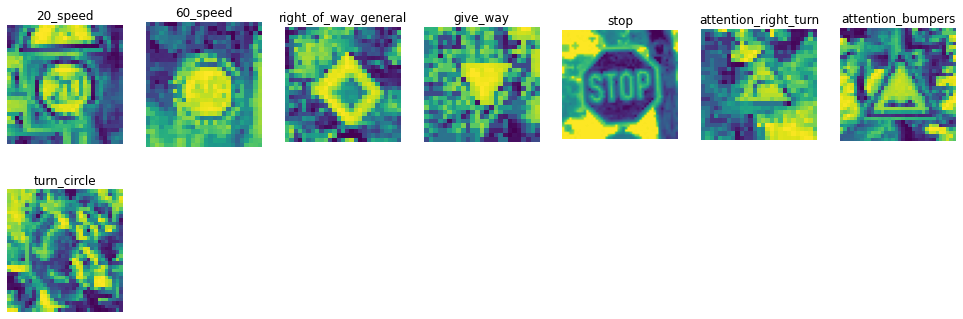

In [ ]:
# przykładowy obraz każdego ze znaków ze zbioru danych
preprocessed_training_dirs = [d for d in os.listdir(TRAINING_DATA_DIR) 
               if os.path.isdir(os.path.join(TRAINING_DATA_DIR, d))]
preprocessed_training_dirs.sort()

training_images = []
for training_dir in preprocessed_training_dirs:
    training_images.append(os.path.join(TRAINING_DATA_DIR, training_dir, "00000_00000.jpg"))


label_number = list(label_map.keys())
i = 0
plt.figure(figsize=(17, 30))
for image in training_images:
    plt.subplot(10,7, i + 1)
    plt.axis('off')
    plt.title("{}".format(label_map[label_number[i]]))
    i += 1
    plt.imshow(Image.open(image))
plt.show()

In [ ]:
# normalizacja
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
# liczba obrazów i liczba klas
image_data = image_generator.flow_from_directory(str(TRAINING_DATA_DIR), target_size=IMAGE_SHAPE)

Found 7770 images belonging to 8 classes.


In [ ]:
# kształt partii obrazu i etykiety
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 8)


Validation dataset

In [ ]:
# wczytanie zbioru testowego
tmp_validation_data_dir = os.path.join(TMP_DATA_DIR, "Final_Test_Images/GTSRB/Final_Test/Images")

In [ ]:
tmp_validation_data_files = [f for f in os.listdir(tmp_validation_data_dir) if f.endswith(".ppm")]
validation_images = []

# eksport plików .jpg
for ppm_file in tmp_validation_data_files:
    image_dir = os.path.join(tmp_validation_data_dir, ppm_file) 
    image = Image.open(image_dir)
    gray_image = cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2GRAY)
    eq_image = cv2.equalizeHist(gray_image)
    directory = VALIDATION_DATA_DIR
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    final_image = os.path.join(directory, image_filename)
    # final_image = cv2.imwrite(os.path.join(directory, image_filename), eq_image)
    image.save(final_image)

    validation_images.append(final_image)
    validation_images.sort()
    
print("Validation images count:", len(validation_images))

Validation images count: 2490


# Training

In [ ]:
# headless model 
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4" 
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))
# returns: size of detected object, vector for each image
feature_batch = feature_extractor_layer(image_batch)


In [ ]:
# false, beacuse next blocks affects next layers
feature_extractor_layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# the output of an algorithm after it has been trained on a historical 
# dataset and applied to new data when forecasting the likelihood of a particular outcome
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 8])

Start training

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'], 
  run_eagerly=True)

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
 
batch_stats_callback = CollectBatchStats()
 
history = model.fit(image_data, epochs=4,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/4
243/243 [==============================] - 1117s 5s/step - loss: 0.3210 - acc: 0.9062
Epoch 2/4
243/243 [==============================] - 1111s 5s/step - loss: 0.1094 - acc: 0.9688
Epoch 3/4
243/243 [==============================] - 1118s 5s/step - loss: 0.1832 - acc: 0.9375
Epoch 4/4
243/243 [==============================] - 1108s 5s/step - loss: 0.1082 - acc: 0.9688


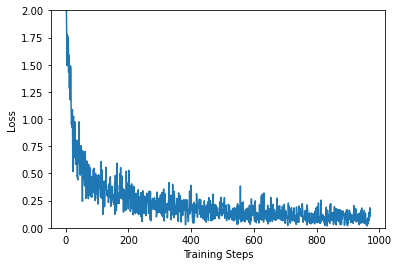

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

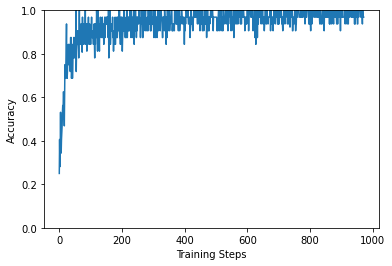

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

# Model evaluation

In [ ]:
tmp_validation_labels_csv = os.path.join(TMP_DATA_DIR, "Final_Test_GT/GT-final_test.csv") 
val_data_frame = pd.read_csv(tmp_validation_labels_csv, header=0, sep=',') 
val_data_frame['Filename'] = val_data_frame['Filename'].str.replace('.ppm','.jpg') 
val_data_frame['ClassId'] = val_data_frame['ClassId'].astype(str).str.zfill(5)

image_val_data = image_generator.flow_from_dataframe(val_data_frame, x_col="Filename", directory=VALIDATION_DATA_DIR, y_col="ClassId", target_size=IMAGE_SHAPE) #(image)

Found 2490 validated image filenames belonging to 8 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for image_val_batch, label_val_batch in image_val_data:
  print("Image batch shape: ", image_val_batch.shape)
  print("Label batch shape: ", label_val_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 8)


In [ ]:
predicted_batch = model.predict(image_val_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_val_batch, axis=-1)

In [ ]:
batch_size = image_val_batch.shape[0]
num_plot_column = 5
num_plot_row = batch_size // num_plot_column + (batch_size % num_plot_column > 0)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
label_number = list(label_map.keys())
print(label_number)
# for n in range(batch_size):
#   plt.subplot(num_plot_row,num_plot_column,n+1)
#   plt.imshow(image_val_batch[label_number[n]])
#   color = "green" if predicted_id[label_number[n]] == label_id[label_number[n]] else "red"
#   plt.title(label_map[predicted_id[label_number[n]]].title(), color=color)
#   plt.axis('off')
# _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# for n in range(batch_size):
#   plt.subplot(num_plot_row,num_plot_column,n+1)
#   plt.imshow(image_val_batch[n])
#   color = "green" if predicted_id[n] == label_id[n] else "red"
#   plt.title(label_map[predicted_id[n]].title(), color=color)
#   plt.axis('off')
# _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")


print("Accuracy of the shown eval batch:")
accuracy_score(label_id, predicted_id)

[0, 3, 12, 13, 14, 20, 22, 40]
Accuracy of the shown eval batch:


0.8125

<Figure size 720x648 with 0 Axes>

In [ ]:
score = model.evaluate(x=image_val_data, batch_size=image_val_data.batch_size, steps=image_val_data.samples/image_val_data.batch_size)
print("Loss: ", score[0], "Accuracy: ", score[1])

77/77 [==============================] - 72s 922ms/step - loss: 0.7185 - acc: 0.7699
Loss:  0.7185150980949402 Accuracy:  0.7698795199394226


# Saving model

In [ ]:
import time
t = time.time()

export_path = f"{OUTPUT_ROOT_DIR}/model{int(t)}"
model.save(export_path, save_format='tf')
tf.keras.models.save_model(model, export_path)
# model.save('saved_model/my_model2', save_format='tf')
model.summary()

export_path

INFO:tensorflow:Assets written to: /output/model1658996340/assets


INFO:tensorflow:Assets written to: /output/model1658996340/assets


INFO:tensorflow:Assets written to: /output/model1658996340/assets


INFO:tensorflow:Assets written to: /output/model1658996340/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 8)                 10248     
                                                                 
Total params: 2,268,232
Trainable params: 10,248
Non-trainable params: 2,257,984
_________________________________________________________________


'/output/model1658996340'

In [ ]:
# converting model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# saving model
with tf.io.gfile.GFile(OUTPUT_TFLITE_MODEL, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpl2b0zko0/assets


INFO:tensorflow:Assets written to: /tmp/tmpl2b0zko0/assets


In [ ]:
# load model + adding TPU
interpreter = tf.lite.Interpreter(model_path=OUTPUT_TFLITE_MODEL)
# interpreter = tf.lite.Interpreter(model_path=export_path) #####
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

batch_size = image_val_batch.shape[0]
predicted_id = np.zeros(batch_size)
 
for i, image in enumerate(np.split(image_val_batch, batch_size)):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  predicted_id[i] = np.argmax(output_data)

label_id = np.argmax(label_val_batch, axis=-1)

num_plot_column = 5
num_plot_row = batch_size // num_plot_column + (batch_size % num_plot_column > 0)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
# label_number = list(label_map.keys())
# for n in range(batch_size):
#   plt.subplot(num_plot_row,num_plot_column,n+1)
#   plt.imshow(image_val_batch[int(n)])
#   color = "green" if predicted_id[int(n)] == label_id[label_number[int(n)]] else "red"
#   plt.title(label_map[predicted_id[int(n)]].title(), color=color)
#   plt.axis('off')
# _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
model.save(f'{OUTPUT_ROOT_DIR}/tpu_saved_model/tf_model')

print("Accuracy of the shown eval batch, with the TensorFlow Lite model:")
accuracy_score(label_id, predicted_id)

INFO:tensorflow:Assets written to: /output/tpu_saved_model/tf_model/assets


INFO:tensorflow:Assets written to: /output/tpu_saved_model/tf_model/assets


Accuracy of the shown eval batch, with the TensorFlow Lite model:


0.8125

<Figure size 720x648 with 0 Axes>

In [ ]:
from google.colab import files
# files.download(f"{OUTPUT_TFLITE_MODEL}")
# files.download(f"/output")

In [ ]:
%cd $OUTPUT_ROOT_DIR
%pwd
%ls -al
%pwd
%ls
!ls -al
!zip -r model1658996340.zip model1658996340

[Errno 2] No such file or directory: '/output'
/content
total 20
drwxr-xr-x 1 root root 4096 Jul 28 16:24 ./
drwxr-xr-x 1 root root 4096 Jul 28 16:19 ../
drwxr-xr-x 4 root root 4096 Jul 13 13:42 .config/
drwx------ 5 root root 4096 Jul 28 16:24 gdrive/
drwxr-xr-x 1 root root 4096 Jul 13 13:43 sample_data/
gdrive/  sample_data/
total 20
drwxr-xr-x 1 root root 4096 Jul 28 16:24 .
drwxr-xr-x 1 root root 4096 Jul 28 16:19 ..
drwxr-xr-x 4 root root 4096 Jul 13 13:42 .config
drwx------ 5 root root 4096 Jul 28 16:24 gdrive
drwxr-xr-x 1 root root 4096 Jul 13 13:43 sample_data
	zip warning: name not matched: model1658996340

zip error: Nothing to do! (try: zip -r model1658996340.zip . -i model1658996340)


In [ ]:
from google.colab import files
files.download("model1658996340.zip")

FileNotFoundError: ignored

In [ ]:
%pwd
%cd gdrive/MyDrive/'Colab Notebooks'/
%ls
!unzip 'tpu_saved_model.zip'

[Errno 2] No such file or directory: 'gdrive/MyDrive/Colab Notebooks/'
/content/gdrive/MyDrive/Colab Notebooks
dataset/  ML_ADAS_Raspberry.ipynb  output/  tpu_saved_model.zip
Archive:  tpu_saved_model.zip
   creating: tpu_saved_model/
   creating: tpu_saved_model/tf_model/
   creating: tpu_saved_model/tf_model/variables/
  inflating: tpu_saved_model/tf_model/variables/variables.index  
  inflating: tpu_saved_model/tf_model/variables/variables.data-00000-of-00001  
   creating: tpu_saved_model/tf_model/assets/
  inflating: tpu_saved_model/tf_model/saved_model.pb  
  inflating: tpu_saved_model/tf_model/keras_metadata.pb  


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('tpu_saved_model/tf_model')
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
files.download("model.tflite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>